# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

age   workclass education_level  education-num  marital-status  \
0   39   State-gov       Bachelors           13.0   Never-married   

      occupation    relationship    race    sex  capital-gain  capital-loss  \
0   Adm-clerical   Not-in-family   White   Male        2174.0           0.0   

   hours-per-week  native-country income  
0            40.0   United-States  <=50K

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data.index)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data.loc[data['income']=='>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data.loc[data['income']=='<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/float(n_records))*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

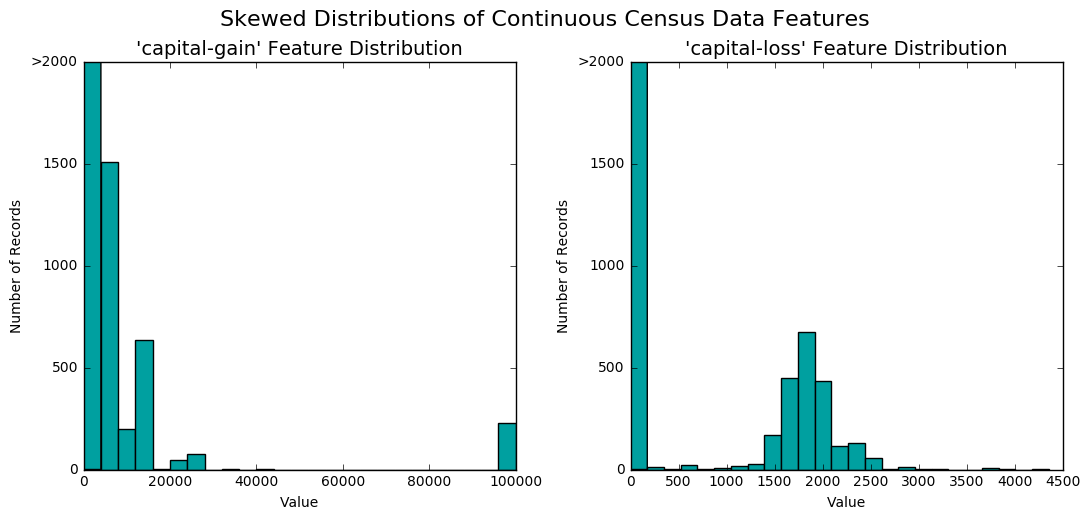

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

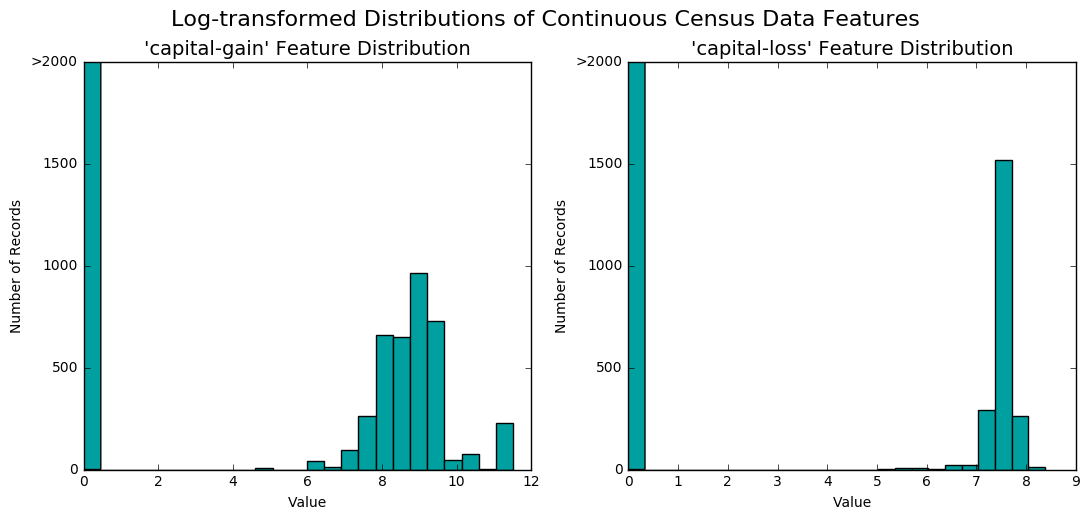

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

age   workclass education_level  education-num  marital-status  \
0  0.30137   State-gov       Bachelors            0.8   Never-married   

      occupation    relationship    race    sex  capital-gain  capital-loss  \
0   Adm-clerical   Not-in-family   White   Male       0.02174           0.0   

   hours-per-week  native-country  
0        0.397959   United-States

### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
def greater_than_50k(value):
    if value == '>50K':
        return 1
    elif value == '<=50K':
        return 0
    
income = income_raw.apply(greater_than_50k)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
# I recommented this line for notebook readability
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# TODO: Calculate accuracy
accuracy = n_greater_50k/float(n_records)

# TODO: Calculate F-score using the formula above for beta = 0.5
bsq=0.5**2
fscore = (1+bsq)*accuracy*1/(bsq*accuracy+1)
# recall = 1 because all positives are inherently returned

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **


1) Decision Trees:
- One use of decision trees is in facial expression recognition.  An example of this is described in the paper "HOG-Based Decision Tree for Facial Expression Classification" by Carlos Orrite, Andrés Gañán, and Grégory Rogez.
- A major strength of decision trees is that they can be implemented to find the important features of a data set using entropy and information gain.  This saves the user the responsibility of selecting the important features on his/her own.  Decision trees are intuitive and easy to understand.  They also perform predictions quite quickly.  They perform best when large sets of training data are available.  They also perform well on problems where labels are not linearly seperable, as they can easily classify points in clusters that may be surrounded by points of a different classification.  Another strength of decision trees is their usefulness in classifications based on features that are continuous as well as those that are discrete or categorical in nature.
- A weakness of decision trees is that they tend to have high variance, due to which, they require large, robust training sets.  With small training sets, decision trees will tend to overfit.  
- Decision trees seem like an effective model for this problem.  Some of our features seem like they may not have much impact on the associated label for a point.  However, from the perspective of someone relatively ignorant to this domain, it is difficult to say with certainity which features are relevant.  A decision tree would use information gain to determine which features to split on, saving us the trouble of trying to determine which features are indeed relevant.  The training set also appears to be fairly large, meaning the decision tree will have enough data to avoid the problems associated with high variance.  Also, we have a mix of continuous as well as discrete features, which decision trees can handle well.

2) Ensemble - AdaBoost:
- Ensemble methods can be used in essentially any application where singular learners are effective.  One example of this is friend/connection recommendations on a social network.
- The strength of ensemble methods is that they can achieve very high accuracy scores.  This is often achievable with less of the threat of overfitting presented by singular learners tuned to achieve similar training scores.  This is possible because, rather than use one very complex model which may be overfit, they can use a collection of simpler models and take the consensus of this collection - by voting for classification, or averaging for regression. For a model such as adaboost, each learner in the ensemble must only do better than chance (50% accuracy).  The more data available, the better an ensemble method will perform.  With AdaBoost, as more data is used, the error of predictions will continue to drop, and the confidence value of predictions will continue to rise.  So this model performs well in scenarios where a lot of data is available, and weak learners are acheivable.
- AdaBoost is not very effective for predicting the probabilities of classifications, only the most likely label.  So, this model is not a good choice if you want to rank the likelihoods of a selection of labels.
- This model is a good choice for the problem at hand because we are doing a binary classification, so we do not need rankings for a set of labels.  AdaBoost also uses decision trees in its ensemble, so we still have the advantage of the model selecting which features are relevant to the predictions, taking that burden off of us.  The data also seems likely to have many easily derived weak learners.  It is plausible that each of the numeric features would have thresholds at which greater than 50% accuracy could be achieved by splitting on that single value.  The same could be true for some of the non-numeric features, such as work-class or occupation.

3) Gaussian Naive Bayes:
- Commonly used for document classification, as is done in the Naive Bayes module of this course.  It can also be used for medical diagnosis, given patients' symptoms, as indicated on Wikipeida
- Naive Bayes is simple and easy to use.  It performs well on data with large feature sets, and it is very efficient.  It performs well in cases where there is not much training data present. 
- One weakness is that it assumes conditional independence of features in the data.  This means that, given two features, the likelihood of a label based on the value of one of the features is not affected by the value of the other feature.  If conditional independence is not a characteristic of the features of the problem, naive bayes may perform poorly, in theory.  Also, the assumption of conditional independence may negate a prediction that is implied by the values of many features, based on the value of just one other feature.  For example, if 4 out of 5 features each indicate that a particular label should be selected with probability of .99, but the 5th feature has not been associated with that label and thus indicates a probability of 0 for that label, multiplying the 5 probabilities together will result in a product of 0.  This would strongly suggest that the label is not an appropriate prediction despite the suggestions of 4 of the 5 features.
- This seems like a good algorithm for the problem, because of its simplicity and ease of use, and the fact that the data probably satisfies conditional independence. 


<i>Honorable Mentions:</i>

K Nearest Neighbors:
- One use of this would be predicting whether a product will sell well at a particular location in a large chain of retail stores.  This could be based off of numerous features like store size, local weather, and local population demographic.
- An advantage of kNN is that it is very simple and easy to understand and implement.  kNN also requires no training, and can be improved as more data points are collected, without the necessity to retrain a model.  kNN performs well on very large data sets, as long as the data can be loaded by the system.  It is also useful in problems where points are not linearly seperable or features are not linear in nature.
- A drawback to kNN is that all of the training data, and any subsequently added data must be loaded into memory or some other quickly accessible storage.  Also, prediction times increase as training data size increases.  In cases where a very large training set is used and predictions need to be made quickly, kNN is not a good option.  It also does not handle missing data well.  If some training points are missing values for a particular feature, that feature must be ignored by the classifier, or accounted for using some less-than-ideal workaround (giving it the average value across the rest of the sample size, for instance).  Also, while the method itself is easy to understand and explain, the results may not be.  With algorithms such as naive bayes or decision trees, you can point to the probabilities, or decision boundaries that led to the result.  With kNN, you can really only say that the label or value is the same as other points which are nearby.
- Since we have used one-hot encoding on the non-numeric features of our data, each of the features can be factored into a distance calculation.  This would allow kNN to operate on the data.  It can be reasonably assumed that people whom we are attempting to classify will likely have similar income to people with similar feature values.  The training data set does not seem to be too large for kNN to be practical, and at least it could be used to determine a reasonable baseline for evaluating other models. 

Support Vector Machines:
- SVMs are commonly used for image classification, according to multiple discussions on the internet and the Wikipedia article on SVMs.
- Advantages of SVM include that it is very versatile due to the kernel trick.  This is because, with some domain knowledge, one can write a custom kernel that is used to determine the hyperplane(s) used for classification.  The kernel trick also enables SVMs to be used in scenarios where data is not linearly seperable.  SVMs also perform very well in cases where there are many featues, and data is sparse.  Sparsity in this context is referring to the condition where the sample points have values of 0 for many of the features.  
- Disadvantages include the fact that these models and their outputs can be difficult to understand and explain.  Also, SVMs have a relatively high number of hyperparameters that need to be tuned to get optimal performance, which can be an unintuitive task.
- In my opinion, this is not a great choice for this problem because the data does not have a large number of features, and all (or nearly all) of the features of values for each sample point.  This does not mean that it would be a bad choice, but the strengths of the algorithm are not leveraged in this scenario.

Logistic Regression



<i>Less Appropriate Candidates:</i> 

Stochastic Gradient Descent Classifier:
- One use of this may be creating a classifier for predicting which political party a particular citizen will vote for in the United States, using a training set of a size on the same order of magnitude as the entire voting population.  This is an idea influenced by Andrew Ng's machine learning class on Coursera.  In his description of SGDC, he explains that it is useful for very large data sets, and mentions hundreds of millions of training examples as a reasonable number to justify its use.
- This algorithm provides an advantage in speed over logistic regression using batch gradient descent, and it can find a similarly accurate predictor function.
- A weakness of this algorithm is that it will not reliably converge on an optimal set of parameters, but rather will oscillate around the optimal parameters.  In a situation where the training set is not large enough to require the use of this algorithm, batch gradient descent with a logistic regression classifier will be a better choice.
- This doesn't seem like a particularly good candidate for this problem because the set of data available is not large enough to justify using it over a batch gradient descent implementation of logistic regression.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [27]:

from sklearn.metrics import (
    accuracy_score,
    fbeta_score)

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(predictions_test,y_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
    
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
    print "{} beta = {}".format(learner.__class__.__name__, fbeta_score(predictions_test,y_test,0.5))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Dependent on which algorithms you chose, the following implementation may take some time to run!

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier beta = 0.546951057616
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier beta = 0.612244897959
DecisionTreeClassifier trained on 36177 samples.
DecisionTreeClassifier beta = 0.620444606414
GaussianNB trained on 361 samples.
GaussianNB beta = 0.623496150144
GaussianNB trained on 3617 samples.
GaussianNB beta = 0.645035183737
GaussianNB trained on 36177 samples.
GaussianNB beta = 0.719893452965
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier beta = 0.597745750185
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier beta = 0.632436990537
AdaBoostClassifier trained on 36177 samples.
AdaBoostClassifier beta = 0.629910080454


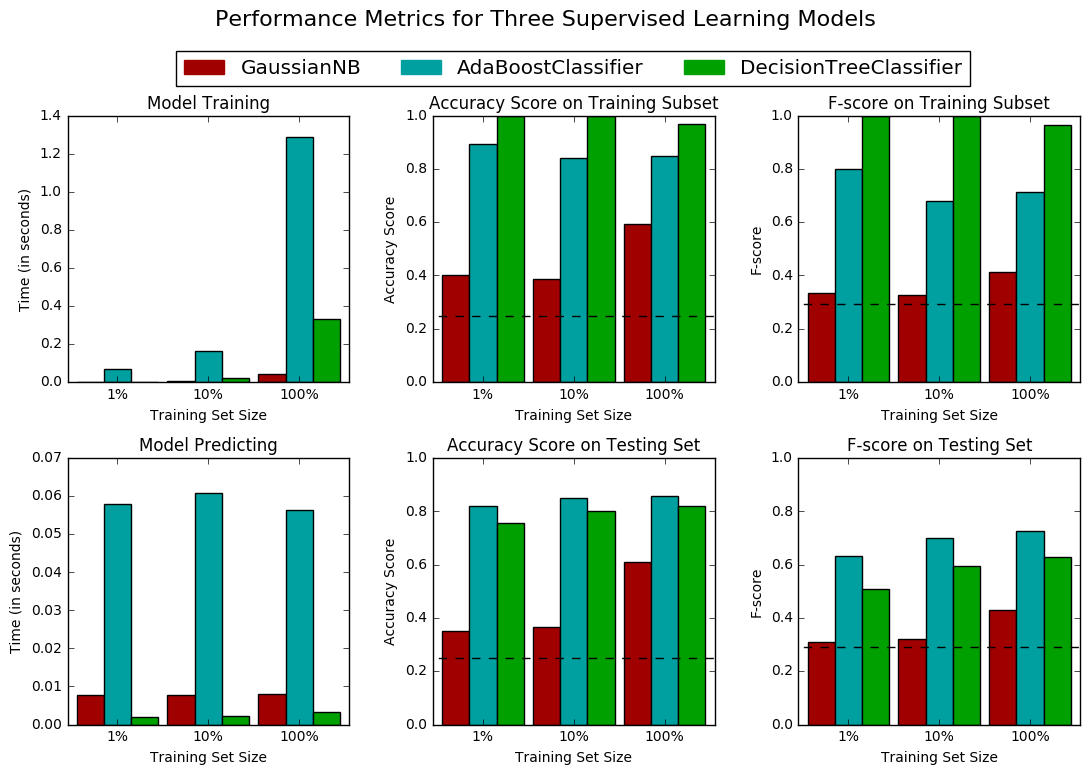

In [28]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import NuSVC

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=42)
clf_B = GaussianNB()
clf_C = AdaBoostClassifier(random_state=37)
#clf_C = NuSVC(random_state=32, nu=0.1)
#clf_C = LogisticRegression()
#clf_B = KNeighborsClassifier()
#clf_C = RandomForestClassifier(random_state=23)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(X_train)/100
samples_10 = len(X_train)/10
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **
Based on the metrics seen from each of the three algorithms selected, a decision tree seems to be the best model for this problem.  Out of the box, the decision tree performed significantly better than Gaussian Naive Bayes, and almost as well as AdaBoost, in terms of accuracy and f-score.  In regards to training and predicting time, the decision tree performed vastly better than AdaBoost, taking a small fraction of the amount of time AdaBoost required.  Gaussian Naive Bayes had similar times to the decision tree, however its accuracy and f-score were quite low, and the algorithm has almost no hyperparameters to tune, so this is approximately the optimal performance it will reach with this training set.  Thus, Gaussian Naive Bayes can be eliminated from contention, leaving us with AdaBoost and the decision tree.  The advantage in out-of-the-box performance seen by AdaBoost is negated by the disadvantage in training and testing time.  Using a decision tree as its base classifier, AdaBoost will not be able to outscore an optimally tuned decision tree by a very large margin, as the decision tree can create a similar decision boundary to AdaBoost, given the right hyperparameters.  Using a tool like grid search can allow us to find the optimal hyperparameters for our algorithm, and it will do this much more quickly with a single decision tree than with an ensemble of trees like with AdaBoost.  Later, any changes to the model or retraining will be quicker with a decision tree, and a decision tree will also provide predictions more quickly.

The decision tree seems appropriate for this problem because many of the continuous features in the data, such as education level, age, and hours worked per week, seem like they would have threshold values that would divide the data very well.  Also some of the discrete features seem like their values could be split into sets where one set would consist mostly of people making $50,000 or more, and the other set would consist of people making less.  These types of features lend the data to being a good candidate for a decision tree.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
A decision tree finds ways to split people up based on the facts we know about them.  It will observe the data and decide which is the most telling trait and what value of that trait best divides the people into sets where one set contains people who make more than $50,000, and the other set contains people who do not.  For instance, it could find that an education level of at least a bachelor's degree is the best split, where 80 percent of people who have at least a bachelor's degree make 50k or more, and 80 percent of people who do not have a least a bachelor's degree make less than 50k.  Now, it will find ways to split up these two new sets.  It could find that, of the people who have bachelor's degrees, 99 percent of those above the age of 28 make 50k or more, while only 50 percent of those below that age do.  Also, for the people without a bachelor's degree, 90 percent of those who work 50 hours or more a week make 50k, while only 30 percent of the people who work less make 50k.  It will continue to split sets that contain a mix of people making above and below 50k.  The algorithm stops splitting a set when it contains only people of one income level, or the algorithm has reached a maximum number of splits, or the set contains a minimum number of people and cannot be split any further.  The algorithm does these splits intelligently, using a forumla which tells it which trait and what splitting value will provide the best split.  

When predicting whether or not a new person makes at least 50k, the algorithm will follow the splits it learned from the sample data.  In our example, it would first check whether the person has an education level of at least a bachelor's degree.  If he/she does not, it will check whether the person works at least 50 hours a week.  If the person does have a bachelor's, it will check if he/she is older than 28 years.  It will continue in this manner until it reaches the end of its series of splits, where a prediction will be made based on the sample points in the final set.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [36]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = DecisionTreeClassifier()
# TODO: Create the parameters list you wish to tune
parameters = {'min_samples_split':[2,6,7,8], 'max_depth':[3,6,7,8], 'min_samples_leaf':[1,2,3]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(DecisionTreeClassifier(random_state=35), parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8177
F-score on testing data: 0.6261

Optimized Model
------
Final accuracy score on the testing data: 0.8533
Final F-score on the testing data: 0.7247


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.2478       |       0.8189      |      0.8533     |
| F-score        |        0.2917       |       0.6287      |      0.7247     |


**Answer: **

The optimized decision tree reaches a significantly higher (about 15%) f-score than the unoptimized decicion tree, and both of these models more than double the F-score of the naive benchmark predictor.  The accuracy of the optimized model is also better than the accuracy of the unoptimized model, but by a smaller margin than is seen with the f-score.  This makes sense, and it seems reasonable to assume that, given a scorer that calculated accuracy rather than f-score, the grid search would have returned an optimized tree that achieved a higher accuracy score.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

1) Education-num : It seems reasonable to assume that the higher level of education a person has, the more likely that person is to make more money.

2) Age : The longer a person has had to work and gain experience, the more likely that person is to make more money.

3) Capital-gain : Having money to invest is probably indicative of higher income.

4) Hours-per-week : By brute force, the more hours someone works, the more money they will make and thus be more likely to earn at least 50,000 dollars.

5) Occupation : Perhaps there is a set of occupations that generally earn at least 50,000; as well as a set of occupations that do not.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

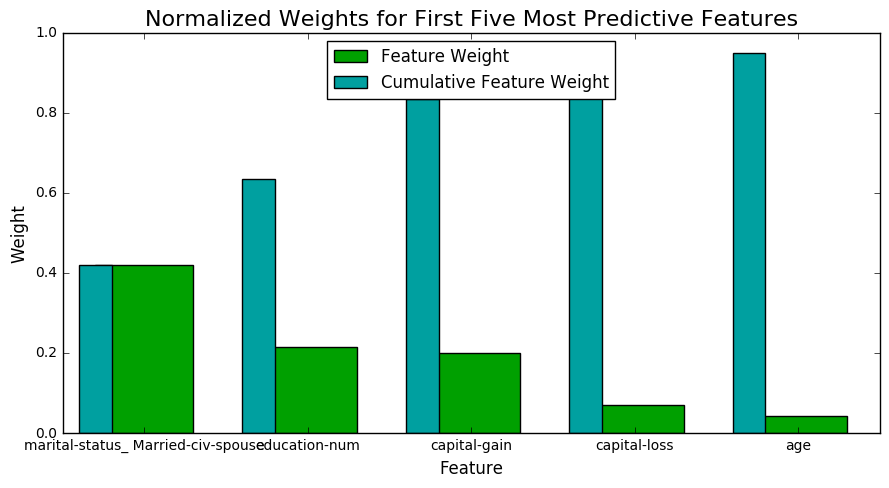

In [38]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
# Will simply use best_clf from above
#model = None

# TODO: Extract the feature importances
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**
Overall, I was close, but I was thinking somewhat narrow mindedly, and focusing on features that could be thought of as having a causal relationship to the amount of income.  What I mean is that I assumed the most relevant features would be the ones that would result in a person making 50,000 or more, not ones that had a correlation with the income.  So, I was thinking that a high education level, a high amount of experience, and many hours worked would result in a higher income, and thus these features would be most important.  I was not really considering the strength of correlative relationships, or perhaps relationships in which the income level could be the cause of the feature.  I did come up with capital gain, but this seems intuitively pretty obvious.  I missed marital status, because my thought process was "what effect would marital status have on your income? Probably not much." as opposed to "what effect would a high income have on your likelihood of being married?"  This latter question seems to be relevant and it makes sense, because as people find themselves more financially stable, they are probably more likely to get married.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [39]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8533
F-score on testing data: 0.7247

Final Model trained on reduced data
------
Accuracy on testing data: 0.8523
F-score on testing data: 0.7200


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

The f-score only decreases by .0047, and the accuracy score only decreases by .001.  I would definitely use this, as the training seemed to occur instantaneously from my perspective.  It seems like it could be effective to use this data set with grid search, to find the best set of hyperparameters for the algorithm.  Then, train a classifier with those hyperparameters and the full training set.  This might make using an ensemble method with grid search more time efficient, so it could be usful to use a decision tree to find the most relevant features, then perform grid search with the reduced data set and an ensemble learner, and then train the ensemble learner with the full data set and the hyperparameters found from grid search.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.